## Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance****

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision.datasets.utils import download_url 
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD 

In [168]:
DOWNLOAD_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"

In [169]:
download_url(DOWNLOAD_URL, ".inputs/")

Using downloaded and verified file: .inputs/insurance.csv


In [170]:
file_path=".inputs/insurance.csv"
data = pd.read_csv(file_path)

In [171]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [172]:
print(data['region'].unique())
data.drop(['region'], axis=1, inplace=True)

['southwest' 'southeast' 'northwest' 'northeast']


In [173]:
max(data['charges']), min(data['charges'])

(63770.42801, 1121.8739)

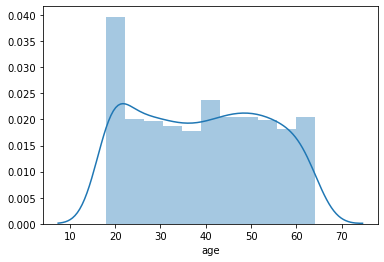

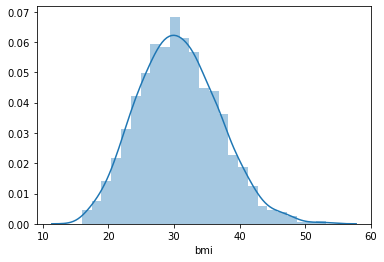

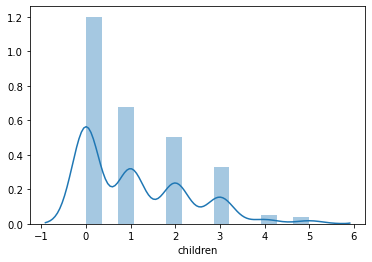

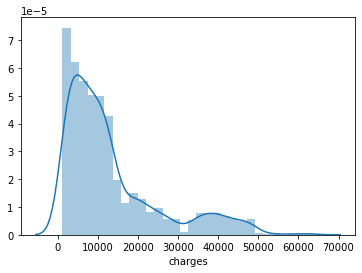

In [174]:
sns.distplot(data['age'])
plt.show()
sns.distplot(data['bmi'])
plt.show()
sns.distplot(data['children'])
plt.show()
sns.distplot(data['charges'])
plt.show()

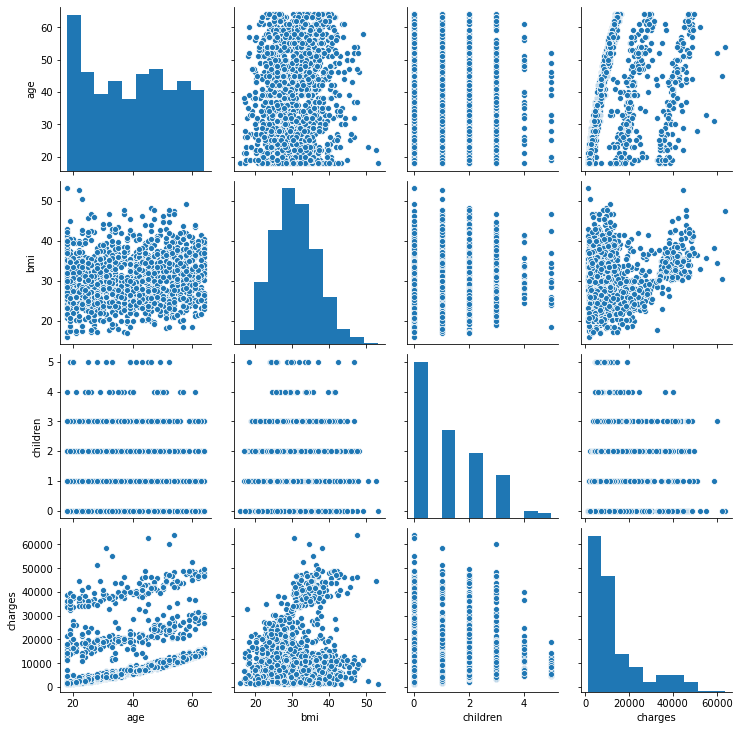

In [175]:
sns.pairplot(data)
plt.show()

In [176]:
def data_preprocessing(data):
    for cat in data.columns:
        data[cat] = data[cat].astype('category').cat.codes
    
    input_data = data.drop('charges', axis=1).values
    target_data = data[['charges']].values
    
    return input_data, target_data

In [177]:
input_data, target_data = data_preprocessing(data)
input_data, target_data

(array([[  1,   0, 197,   0,   1],
        [  0,   1, 350,   1,   0],
        [ 10,   1, 331,   3,   0],
        ...,
        [  0,   0, 422,   0,   0],
        [  3,   0, 146,   0,   0],
        [ 43,   0, 229,   0,   1]], dtype=int16),
 array([[1005],
        [  57],
        [ 306],
        ...,
        [  32],
        [  91],
        [1171]], dtype=int16))

In [178]:
input_data.shape, target_data.shape

((1338, 5), (1338, 1))

In [179]:
dataset = TensorDataset(torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32))
train_data, val_data = random_split(dataset, [1000, 338])

In [180]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size*2) 

In [181]:
input_size = 5
outpur_size = 1
batch_size = 32
lr = 1e-6

In [182]:
class InsurancePredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, outpur_size)
    
    def forward(self, xb):
        outputs = self.linear(xb)
        return outputs
    
    def trainig_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.mse_loss(outputs, targets)
        return loss
        
    def validation_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.mse_loss(outputs, targets)
        
        return {"loss": loss.detach()}
        
    def validation_epoch_end(self, outputs):
        val_outputs = [x['loss'] for x in outputs]
        val_mean = torch.stack(val_outputs).mean()
        return {"loss": val_mean.item()}
        
    def epoch_end(self, epoch, val_loss):
        print("epoch: {0}, val_loss: {1}".format(epoch, val_loss['loss']))
        

In [183]:
model = InsurancePredictionModel()

def evaluate(model, val_loader):
    epoch_result = [model.validation_step(batch) for batch in val_loader]
    result = model.validation_epoch_end(epoch_result)
    return result

In [184]:
val_loss = evaluate(model, val_loader)
val_loss

{'loss': 492123.875}

In [185]:
def fit(model, epochs, train_loader, val_loader, optim, lr):
    history=[]
    optim = optim(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.trainig_step(batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result['loss'])
    return history

In [186]:
history = fit(model, 10, train_loader, val_loader, SGD, lr)

epoch: 0, val_loss: 207826.359375
epoch: 1, val_loss: 204953.859375
epoch: 2, val_loss: 199994.984375
epoch: 3, val_loss: 200953.1875
epoch: 4, val_loss: 195601.5625
epoch: 5, val_loss: 192308.859375
epoch: 6, val_loss: 192006.015625
epoch: 7, val_loss: 188515.640625
epoch: 8, val_loss: 184652.5625
epoch: 9, val_loss: 183912.9375


In [187]:
x, y = val_data[10]
x.unsqueeze(0)
model(x)[0].detach(), y

(tensor(463.5345), tensor([522.]))

In [188]:
x, y = val_data[10]
x.unsqueeze(0)
model(x)[0].detach(), y

(tensor(463.5345), tensor([522.]))

In [189]:
val_loss['loss']

492123.875

In [190]:
history

[207826.359375,
 204953.859375,
 199994.984375,
 200953.1875,
 195601.5625,
 192308.859375,
 192006.015625,
 188515.640625,
 184652.5625,
 183912.9375]

In [191]:
[val_loss['loss']]+history

[492123.875,
 207826.359375,
 204953.859375,
 199994.984375,
 200953.1875,
 195601.5625,
 192308.859375,
 192006.015625,
 188515.640625,
 184652.5625,
 183912.9375]

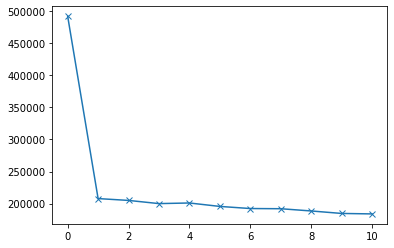

In [193]:
result = [int(r) for r in [val_loss['loss']]+history]
plt.plot(result, '-x')
plt.show()